# Stockes Flow

In [1]:
#importing libraries
import numpy
import numba
from numba import jit
from matplotlib import pyplot
%matplotlib inline

#defining grid
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#initial guess
p = numpy.zeros((ny,nx))
w = numpy.zeros((ny,nx))

#dérivative of p along the top border
u=1.

l1_target = 1e-6

In [2]:
@jit
def L1norm(new, old):
    '''Calculate l1 norm between new and old
    
    Parameters:
    ----------
    new : Array of floats
        
    old : Array of floats
    
    Returns:
    -------
    norm : double
            value of the l1 Norm
    '''
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [3]:
@jit
def poisson_2d_1step(p, b, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    pd = p.copy()
   
    p[1:-1,1:-1] = 1.0/(2.0*(dx**2 + dy**2)) * ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 + (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 - b[1:-1,1:-1]*dx**2*dy**2)
    
    #enforcing BC elsewhere
    return p 

def laplace_2d_1step(p, dx, dy):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    dx: float
         spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    pd = p.copy()
    
    p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 + (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2)
    
    #enforcing BC elsewhere   
    return p


In [4]:
@jit
def enforceBCphi(p):
    '''Enforce the boundary conditions for phi
    
    Parameters:
    ----------
    p : 2D array of floats
        solution before applying BC
    
    Returns:
    -------
    p_out : 2D array of floats
        solution after applying BC
    '''
#dirichlet condition
    p_out=p.copy()
    #top
    p_out[:,-1]=0.
    #bottom
    p_out[:,0]=0.
    #left
    p_out[0,:]=0.
    #right
    p_out[-1,:]=0.
    
    return p_out

def enforceBCw(w,p,dx,dy,u):
    '''Enforce boundary conditions for w
    
    Parameters:
    ----------
    w : solution before applying BC
    p : source term for bc
    dx : 
    
    
    Returns:
    -------
    w_out : solution after applying BC 
    '''
    
    #neumann + laplace
    w_out=w.copy()
    #bottom
    w_out[0,:]=-(8*p[1,:]-p[2,:])/2/dy/dy
    #left
    w_out[1:-1,0]=-(8*p[1:-1,1]-p[1:-1,2])/2/dx/dx
    #right
    w_out[1:-1,-1]=-(8*p[1:-1,-2]-p[1:-1,-3])/2/dx/dx
    #top
    w_out[-1,:]=-(8*p[-2,:]-p[-3, :])/2/dy/dy - 3*u/dy
    return w_out


In [5]:
#solve the biharmonic équation as a laplace and a poisson coupled equation
@jit
def biHarmonicSolver(p, w, dx, dy, l1Target, u):
    '''Performs Jacobi relaxation
    
    Parameters:
    ----------
    p : 2D array
        initial guess for p
    w : 2D array
        initial quess for w
    dx : float
        grid width in x
    dy : float
        grid width in y
    l1Target : float
        Target for the l1 norm between two iteration
    u : float
        parameter for bc
    
    Returns:
    -------
    p: 2D array
        solution for p
    w: 2D array
        solution for w
    l1phi : float
        l1 norm between two last iteration for p
    l1w : float
        l1 norm between two last iteration for w
    '''
    l1phi=l1Target+1
    l1w=l1Target+1
    nbStep=0
    #we have to force a few loop for the problem to start converging fast enough for l1-norm > target l1-norm
    while l1phi>l1Target or l1w>l1Target or nbStep<=2:
        pd=p.copy()
        wd=w.copy()
        p = poisson_2d_1step(pd, -wd, dx, dy)
        p = enforceBCphi(pd)
        l1phi= L1norm(p, pd)
        w = laplace_2d_1step(wd, dx, dy)
        w = enforceBCw(wd, pd, dx, dy, u)
        l1w=L1norm(w, wd)
        nbStep=nbStep+1
    print("number of steps: ")
    print(nbStep)
    return p, w, l1phi, l1w

In [6]:
#we solve équation and check the résult
p, w, l1phi, l1w = biHarmonicSolver(p, w, dx, dy, l1_target, u)
#we check that l1-norm is < target
print(l1phi, l1w)
print(p[32,::8])
print(numpy.max(numpy.abs(p)))
print("wesh")
print(numpy.max(numpy.abs(w)))

number of steps: 
3360
0.0 9.976556762884142e-07
[ 0.         -0.05747874 -0.09442319 -0.09442319 -0.05747874  0.        ]
0.0998451697451
wesh
120.0


<function matplotlib.pyplot.colorbar>

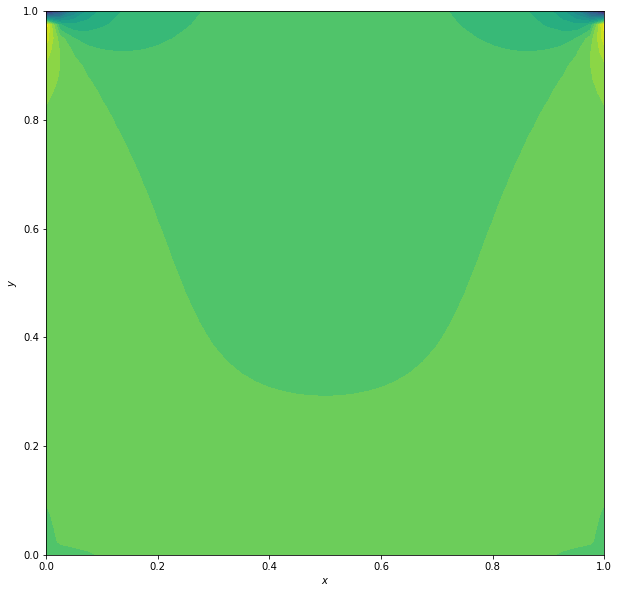

In [7]:
#print w
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,w,20)
#pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

<function matplotlib.pyplot.colorbar>

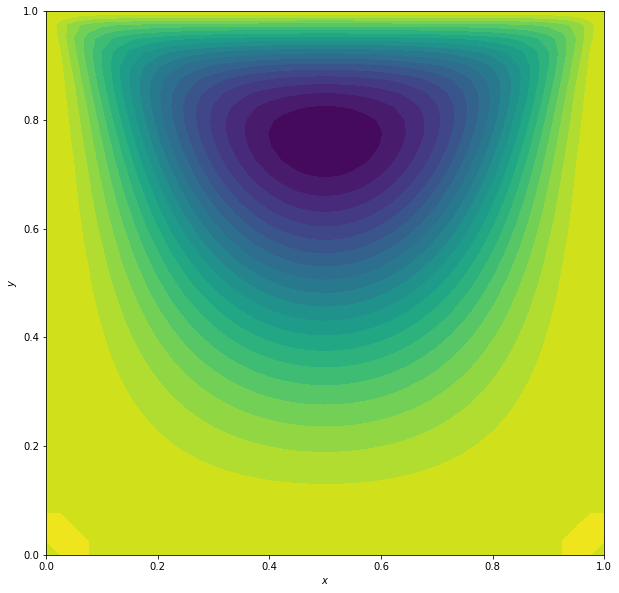

In [8]:
#print phi
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
#pyplot.contourf(x,y,w,20)
pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

On peut discrétiser $\nabla ^4 = \partial ^4_x + 2\partial^2_x\partial^2_y + \partial^4_y$ de la manière suivante :

\begin{equation}
\nabla^4 u(i,j) = \frac{u(i+2, j) + u(i-2, j) + 6u(i, j) - 4 u(i+1, j) - 4u(i-1, j)}{dx^4} + \frac{u(i, j+2) + u(i, j-2) + 6u(i, j) - 4 u(i, j+1) - 4u(i, j-1)}{dy^4} + 2 \frac{u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1) -2(u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) +4u(i,j)}{dx^2 dy^2}
\end{equation}

Ce qui donne pour dx = dy :

\begin{equation}
\nabla^4 u(i,j) = [u(i+2, j) +u(i-2, j) + u(i, j+2) + u(i, j-2)) + 2 (u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1)) -8 (u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) + 20 u(i,j)]2/dx^4
\end{equation}

Et donc l'évolution se fait comme (on peut aisément améliorer ceci grâce à SOR) :
\begin{equation}
u(i,j)^{k+1} = -[u(i+2, j) +u(i-2, j) + u(i, j+2) + u(i, j-2)) + 2 (u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1)) -8 (u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1))]^k/20
\end{equation}

ou $[...]^k$ signifie "évaluer la fonction au temps k"

Conditions au bord :

On observe qu'on ne peut pas utiliser cette formule pour les deux bandes les plus proches du bord. 
Les conditions de Dirichlet sont évidente à implémenter. Passons à celles de Neumann.

Pour les points près de la forntière nous pouvons approximer le point manquant avec une extrapolation quadratique qui nous donne :
\begin{equation}
\nabla^4 u(i,j)= \frac{2}{dx^4}(21u(i,j) -8 (u(i+1, j) + u(i-1, j) + u(i, j+1) + u(i, j-1)) + 2 (u(i+1, j+1) + u (i+1, j-1) + u(i-1, j+1) + u(i-1, j-1)) + u(i+2, j) + + u(i, j+2) + u(i, j-2))+ h*du(i,j))
\end{equation}

près du bord gauche par exemple où du(i,j) est la dérivée dans le sens des x en ce point.

In [3]:
#defining grid
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

#initial guess
p = numpy.zeros((ny,nx))#random.rand(ny,nx)/100
w = numpy.zeros((ny,nx))

#dérivative of p along the top border
u=1.

l1_target = 1e-6

In [7]:
def biharmonic(u):
    biharm=numpy.zeros(u.shape)
    biharm[2:-2,2:-2] = u[2:-2,2:-2]*21 + u[4:,2:-2] +u[:-4, 2:-2] + u[2:-2, 4:] + u[2:-2, :-4] + 2*(u[3:-1, 3:-1] + u[3:-1, 1:-3] + u[1:-3, 3:-1] + u[1:-3, 1:-3]) - 8*(u[3:-1,2:-2] + u[1:-3, 2:-2] + u[2:-2, 3:-1] + u[2:-2, 1:-3])
    return biharm

In [38]:
def enforce_BC(u_old, v, dx):
    u = u_old.copy()
     #enforce neumann, dirichlet are automaticaly enforced
    u[0,:]=1
    u[:,0]=0
    u[-1,:]=0
    u[:,-1]=0
    #corners
    u[1,1] =  -(2*u_old[2,2] - 8*(u_old[2,1] + u_old[1,2]) + u_old[3,1] + u_old[1,3])/21
    u[1,-2] = -(2*u_old[2,-3] - 8*(u_old[2,-2] + u_old[1,-3]) + u_old[1,-4] + u_old[3,-2])/21
    u[-2,1] = -(2*v*dx + 2*u_old[-3,2] - 8*(u_old[-2,2] + u_old[-3,1]) + u_old[-4,1] + u_old[-2,3] ) / 21
    u[-2,-2] =-(2*v*dx + 2*u_old[-3,-3] - 8*(u_old[-2,-3] + u_old[-3,-2]) + u_old[-2,-4] + u_old[-4,-2])/21
    #borders
    #left
    u[2:-2,1] =-((u_old[4:,1] + u_old[:-4, 1] + u_old[2:-2, 3]) + 2*(u_old[3:-1, 2] + u_old[1:-3, 2]) - 8*(u_old[3:-1,1] + u_old[1:-3, 1] + u_old[2:-2, 2] ))/21
    #right
    u[2:-2,-2] =-((u_old[4:,-2] + u_old[:-4, -2] + u_old[2:-2, -4]) + 2*(u_old[3:-1, -3] + u_old[1:-3, -3]) - 8*(u_old[3:-1,-2] + u_old[1:-3, -2] + u_old[2:-2, -3]))/21 
    #top
    u[-2,2:-2] = -((2*v*dx + u_old[-4, 2:-2] + u_old[-2, 4:] + u_old[-2, :-4]) + 2*(u_old[-3, 3:-1] + u_old[-3, 1:-3]) - 8*(u_old[-3, 2:-2] + u_old[-2, 3:-1] + u_old[-2, 1:-3]))/21
    #bottom
    u[1,2:-2] = -((u_old[3,2:-2] + u_old[1, 4:] + u_old[1, :-4]) + 2*(u_old[2, 3:-1] + u_old[2, 1:-3]) -  8*(u_old[2,2:-2] + u_old[1, 3:-1] + u_old[1, 1:-3]))/21

    return u

def conjugate_gradient_2d(p, dx, dy, l1_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l1_norm = 1+l1_target
    iterations = 0
    l2_conv = []
    n=0
    v=1
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r = -biharmonic(p).copy()
    r=enforce_BC(r, v, dx)
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = biharmonic(d)
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target or n<3and n<15:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = biharmonic(d)
        sigma = numpy.sum(d*Ad)
        r=enforce_BC(r, v, dx)
        p=enforce_BC(p, v, dx)
        
        l1_norm = L1norm(pk,p)
        iterations += 1
        l2_conv.append(l1_norm)
        n=n+1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     


In [39]:
p = conjugate_gradient_2d(p, dx, dy, l1_target)[0]

Number of CG iterations: 3


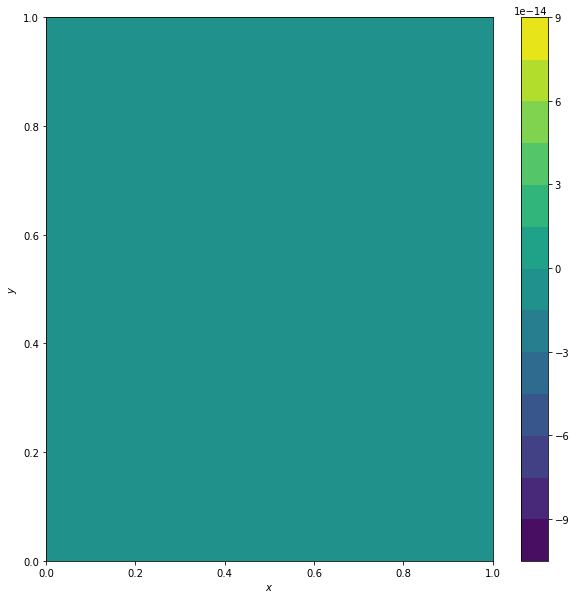

In [40]:
#print w
x=numpy.linspace(0, l, nx)
y=numpy.linspace(0, h, ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,w,15)
#pyplot.contourf(x, y, p, 20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

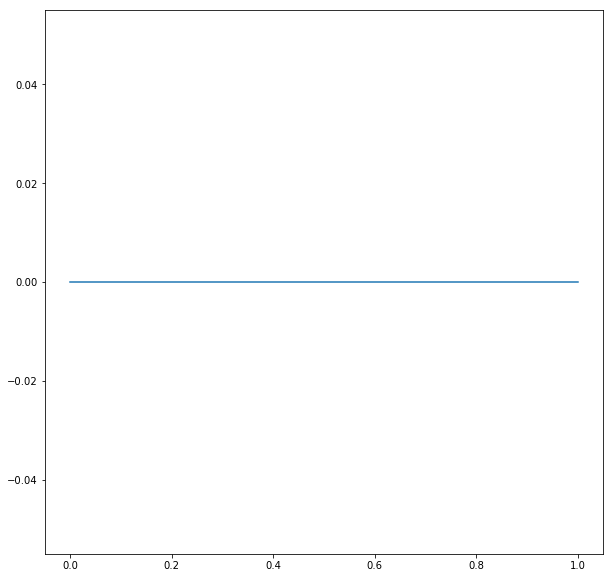

In [41]:

pyplot.figure(figsize=(10,10))
pyplot.plot(x[:],w[:,20])

In [206]:
print(numpy.max(numpy.abs(w)))

0.0115786614794


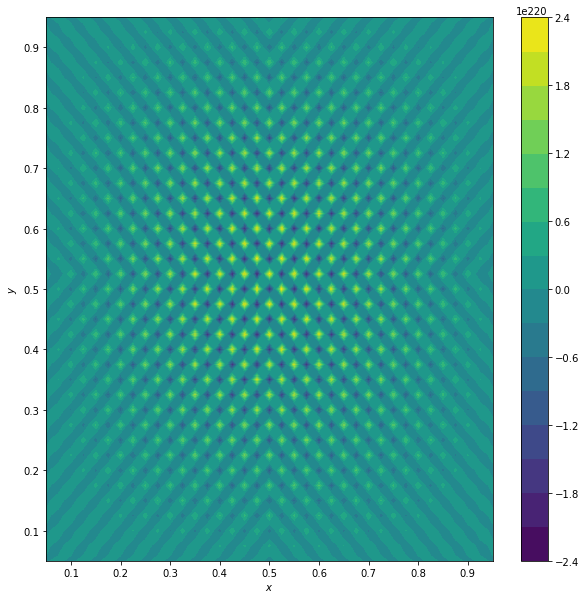